# Deep Learning - S&P 500 Close Prediction Project

### Daniel Fields - Spring 2018
   
This project was done in participation for the ERP PREDICTION CONTEST hosted through University of California, Santa Barbara's Probability and Statistics Department that took place on February 15, 2019 - May 15, 2019. In this competion, the competitors were given a dataset of many Market Indicators, and the task was to predict the 2019 S&P 500 prices 5 days in advance. 

In my teams project, we worked on Vector Error Correction Models, Aggregate Linear Models, and Deep Learning models to predict the S&P 500 close price for 2019 with each team member assesing the vability of a given model class. My team ended up not wanting to proceed with the competion, but I used the dataset and the knowledge I had gained in researching the viability of deep learning models to build a LSTM model to predict S&P 500 close. Below is my personal effort to create a LSTM and asses its fit on the training set. 

Note: This project should have a test set and accuracy assement of the predictions produced, but as I was wokring with an already-made dataset of market measures and I did not know how to obtain all of those indicators. So, I decided instead to split the training set into a small test set and a training set, even though the goal of this was originally to use 2018 data to predict 2019. 

In [9]:
# Make sure that you have all these libaries available to run the code successfully
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import os
import seaborn as sns
import numpy as np
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error
%matplotlib inline

**Working Dataset Key**
- data = orginal: (16612, 59)
- data1 = removed all rows with `NA` for `ASPFWR5`: (14590, 55)
- data2 = top 20 correlated variables that do not have NA's: (14590, 20)

In [10]:
# Load Data
data = pd.read_csv("dataset.csv")
# Find instance of last missing ASPFWR5 
last_zero = np.max(np.where(pd.isnull(data["ASPFWR5"]))) + 1
# Select rows only with non missing ASPWR5 values
data1 = data.iloc[last_zero:]
#Drop columns with almost all missing values
data1 = data1.drop(["sentiment1","sentiment2","sentiment3","Hulbert.sentiment"], axis = 1)
#Relabel indexes
data1 = data1.reset_index(drop = True)
#Format Dates
data1 = data1.rename(columns = {"Unnamed: 0":"Date"})
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14590 entries, 0 to 14589
Data columns (total 55 columns):
Date        14590 non-null object
ASPFWR5     14590 non-null float64
US10YR      13981 non-null float64
EPS         14590 non-null float64
PER         14590 non-null float64
OPEN        14590 non-null float64
HIGH        14590 non-null float64
LOW         14590 non-null float64
CLOSE       14590 non-null float64
BDIY        8317 non-null float64
VIX         7056 non-null float64
PCR         5281 non-null float64
MVOLE       3523 non-null float64
DXY         11835 non-null float64
ASP         14590 non-null float64
ADVDECL     14590 non-null float64
FEDFUNDS    14590 non-null float64
NYSEADV     6951 non-null float64
IC          6951 non-null float64
BAA         14590 non-null float64
NOS         12528 non-null float64
BER         6951 non-null float64
DVY         14590 non-null float64
PTB         7035 non-null float64
AAA         14590 non-null float64
SI          14590 non-nul

## Feature Selection

In [11]:
correlations_to_close = data1.corr(method ='pearson')["CLOSE"]
#Since Close price has a 100% correlation with itself, we will drop it from the feature correlation array
correlations_to_close = correlations_to_close.drop("CLOSE", axis = 0) 

In [12]:
#Create a datframe to analyze features on
    # we will select features based on (1) not having missing values and (2) being correlated to close price
num_NA = pd.DataFrame()
num_NA["Num_NA"] = data1.isnull().sum(axis = 0)
num_NA["corr"] = correlations_to_close

num_NA["val_corr"] = np.abs(correlations_to_close)
num_NA.head()

,Num_NA,corr,val_corr
Date,0,NaN,NaN
ASPFWR5,0,0.004114,0.004114
US10YR,609,-0.651848,0.651848
EPS,0,0.941518,0.941518
PER,0,0.422391,0.422391


Text(0.5, 1.0, 'Which variables should we use?')

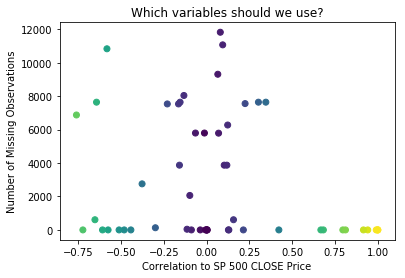

In [13]:
plt.scatter(y = num_NA["Num_NA"],x = num_NA["corr"], c = num_NA["val_corr"])
plt.ylabel("Number of Missing Observations")
plt.xlabel("Correlation to SP 500 CLOSE Price")
plt.title("Which variables should we use?")

Going to use variables that are complete and have greater than 10% correlation to S&P 500 Close price.

In [14]:
variables_selected = num_NA.query("Num_NA ==0").query("val_corr > 0.1")
variables_selected

,Num_NA,corr,val_corr
EPS,0,0.941518,0.941518
PER,0,0.422391,0.422391
OPEN,0,0.999910,0.999910
HIGH,0,0.999956,0.999956
LOW,0,0.999958,0.999958
ASP,0,0.991270,0.991270
ADVDECL,0,0.796050,0.796050
FEDFUNDS,0,-0.575024,0.575024
BAA,0,-0.480811,0.480811
DVY,0,-0.722279,0.722279


In [15]:
data2 = data1[list(variables_selected.index) + ["CLOSE"]]
data2.head()

,EPS,PER,OPEN,HIGH,LOW,ASP,ADVDECL,FEDFUNDS,BAA,DVY,...,SI,URR,PPIR,US3M,BBY,INDPRO,CAPE,CATY,INF,CLOSE
0,3.39,17.221239,58.38,58.38,58.38,1.020065,0.0,4.0,5.34,0.031739,...,0.95,0,0,4.49,0.0,221.264931,18.393526,32.985615,0.015074,58.38
1,3.39,17.076696,57.89,57.89,57.89,1.011635,0.0,4.0,5.34,0.032014,...,0.95,0,0,4.37,0.0,221.264931,18.238151,32.707524,0.015074,57.89
2,3.39,16.893805,57.27,57.27,57.27,1.000931,0.0,4.0,5.34,0.032367,...,0.95,0,0,4.31,0.0,221.264931,18.041839,32.356003,0.015074,57.27
3,3.39,16.834808,57.07,57.07,57.07,0.997567,0.0,4.0,5.34,0.032487,...,0.95,0,0,4.30,0.0,221.264931,17.977855,32.241784,0.015074,57.07
4,3.39,16.876106,57.21,57.21,57.21,1.000145,0.0,4.0,5.34,0.032413,...,0.95,0,0,4.27,0.0,221.264931,18.020979,32.319646,0.015074,57.21


## Preproccesing
- Scale Data
- Split the data into train and test splits
- Standardize the data between -1 and 1

In [46]:
#scaler = MinMaxScaler()
#X_scaled = scaler.fit_transform(X)

#80-20 Split
X_trn = X.head(int(0.8*14590)).values.reshape(int(0.8*14590),20,1)
X_tst = X.tail(int(0.2*14590)).values.reshape(int(0.2*14590),20,1)

y_trn = y.head(int(0.8*14590)).values
y_tst = y.tail(int(0.2*14590)).values

# LSTM 
## Keras

Input Shape Notes: https://machinelearningmastery.com/reshape-input-data-long-short-term-memory-networks-keras/
- The input to every LSTM layer must be three-dimensional.
    1. Samples. One sequence is one sample. A batch is comprised of one or more samples.
    2. Time Steps. One time step is one point of observation in the sample.
    3. Features. One feature is one observation at a time step

# Tensoflow 2.0 Model Implentation through Keras

In [47]:
from __future__ import absolute_import, division, print_function, unicode_literals

### Build Model Architecture

In [248]:
lstm1 = Sequential()
lstm1.add(Dense(X_trn.shape[1], activation = "sigmoid", input_shape=(None, X_trn.shape[2])))
lstm1.add(Dropout(0.4))
lstm1.add(LSTM(14, activation = "softmax", return_sequences = False))
lstm1.add(Dense(5))
#lstm1.add(LSTM(14, return_sequences = True))
lstm1.add(Dropout(0.4))
lstm1.add(Dense(1,input_shape = (None,1)))
lstm1.compile(loss = "mean_squared_error", optimizer = "adam",metrics = ["mean_squared_error"])
lstm1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_97 (Dense)             (None, None, 20)          40        
_________________________________________________________________
dropout_64 (Dropout)         (None, None, 20)          0         
_________________________________________________________________
lstm_60 (LSTM)               (None, 14)                1960      
_________________________________________________________________
dense_98 (Dense)             (None, 5)                 75        
_________________________________________________________________
dropout_65 (Dropout)         (None, 5)                 0         
_________________________________________________________________
dense_99 (Dense)             (None, 1)                 6         
Total params: 2,081
Trainable params: 2,081
Non-trainable params: 0
_________________________________________________________________


### Fit the model

In [208]:
fit_norm = lstm1.fit(X_trn, y_trn, validation_split = 0.2, batch_size = 1459, epochs = 50, verbose = 2)

Train on 9337 samples, validate on 2335 samples
Epoch 1/50
 - 3s - loss: 7256.3926 - mean_squared_error: 7256.3926 - val_loss: 8580.0731 - val_mean_squared_error: 8580.0731
Epoch 2/50
 - 1s - loss: 6887.1331 - mean_squared_error: 6887.1331 - val_loss: 5907.6099 - val_mean_squared_error: 5907.6099
Epoch 3/50
 - 1s - loss: 6822.0186 - mean_squared_error: 6822.0186 - val_loss: 10913.7175 - val_mean_squared_error: 10913.7175
Epoch 4/50
 - 1s - loss: 6750.9124 - mean_squared_error: 6750.9124 - val_loss: 10213.2809 - val_mean_squared_error: 10213.2809
Epoch 5/50
 - 1s - loss: 6971.6568 - mean_squared_error: 6971.6568 - val_loss: 7187.8468 - val_mean_squared_error: 7187.8468
Epoch 6/50
 - 1s - loss: 6732.7679 - mean_squared_error: 6732.7679 - val_loss: 10959.2326 - val_mean_squared_error: 10959.2326
Epoch 7/50
 - 1s - loss: 7017.6286 - mean_squared_error: 7017.6286 - val_loss: 14293.6856 - val_mean_squared_error: 14293.6856
Epoch 8/50
 - 1s - loss: 6849.2065 - mean_squared_error: 6849.2065 - 

### Analyze Training
 _Note: We do not observe convergence, but after testing predictions I deemed the fit to be satisfactory and to avoid overfitting I stopped training after 50 epochs and using validation testing throughout._

Text(0.5, 1.0, 'Training')

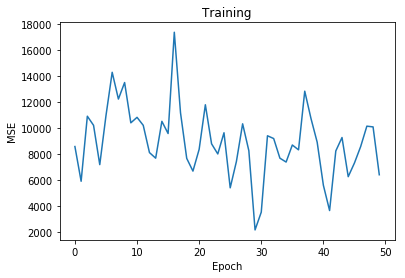

In [211]:
plt.plot(fit_norm.history["mean_squared_error"])
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Training")

### Examine Predictions on the _Test Set_

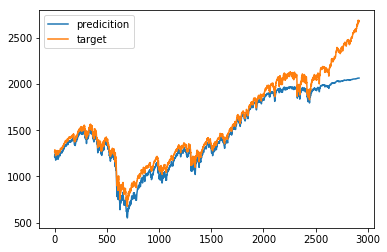

In [212]:
preds = lstm1.predict(X_tst)

plt.plot(preds, label = "predicition")
plt.plot(y_tst, label = "target")
plt.legend()

Thank you for your time and attention. - Daniel Fields